In [ ]:
# import data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve

In [ ]:
# Plotting utility
from IPython.display import clear_output
class PlotLosses(tf.keras.callbacks.Callback):
    def __init__(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1

        clear_output(wait=True)
        fig, axes = plt.subplots(1,2,figsize=(8,3))

        axes[0].plot(self.x, self.losses, label="Train loss")
        axes[0].plot(self.x, self.val_losses, label="Validation loss")
        # axes[0].set_yscale('log')
        axes[0].set_xlabel('Number of epochs')
        axes[0].set_ylabel('Losses')
        axes[0].legend()

        axes[1].plot(self.x, self.acc, label="Train accuracy")
        axes[1].plot(self.x, self.val_acc, label="Validation accuracy")
        axes[1].set_xlabel('Number of epochs')
        axes[1].set_ylabel('Accuracy')
        # axes[1].set_ylim(0.85,1.)
        axes[1].legend()

        plt.tight_layout()
        plt.show();

In [ ]:
nupur_path = '/content/gdrive/MyDrive/Colab Notebooks'
sophia_path = '/content/gdrive/MyDrive/Colab Notebooks'
afham_path = '/content/gdrive/MyDive/Colab Notebooks'

In [ ]:
data_dir = sophia_path

In [ ]:
# load images as matrices with a defined shape, create the input and output for the CNN
batch_size = 128
img_height = 128
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale")

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
    color_mode="grayscale")

Found 1372 files belonging to 2 classes.
Using 1098 files for training.
Found 1372 files belonging to 2 classes.
Using 274 files for validation.


In [ ]:
# normalize datasets

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0063036154 0.38747704


In [ ]:
# build the CNN and train

num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(6, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(6, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

plot_losses = PlotLosses();

model.build((None, img_height, img_width, 1))

model.summary()



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 128, 128, 1)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 126, 126, 6)       60        
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 63, 63, 6)         0         
 ng2D)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 23814)             0         
                                                                 
 dense_20 (Dense)            (None, 6)                 142890    
                                                                 
 dense_21 (Dense)            (None, 2)                 14        
                                                     

<Figure size 640x480 with 0 Axes>

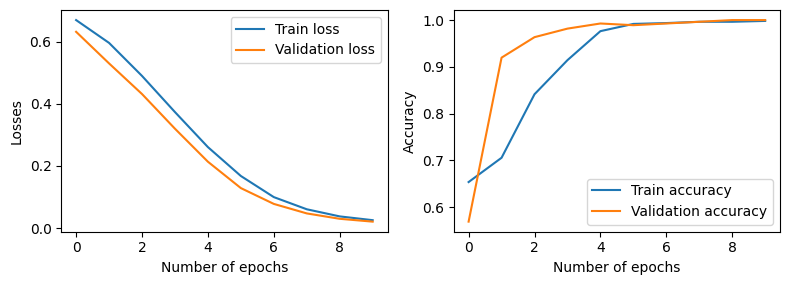

9/9 [==============================] - 6s 211ms/step


array([[0.9803359 , 0.01966405],
       [0.00321902, 0.996781  ],
       [0.97738856, 0.02261142],
       ...,
       [0.00555775, 0.9944424 ],
       [0.08401965, 0.9159803 ],
       [0.99140316, 0.00859691]], dtype=float32)

In [ ]:
# look at performance

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10, callbacks=[plot_losses]
  )

model.predict(train_ds)

In [ ]:
print(model.predict(train_ds))
print(model.predict(val_ds))

9/9 [==============================] - 7s 328ms/step
[[0.00544732 0.9945526 ]
 [0.9800988  0.0199012 ]
 [0.00327134 0.9967286 ]
 ...
 [0.00587024 0.99412966]
 [0.00753463 0.9924654 ]
 [0.98202604 0.01797396]]
3/3 [==============================] - 2s 129ms/step
[[0.11492658 0.88507336]
 [0.9886859  0.01131418]
 [0.08812994 0.91187   ]
 [0.98253095 0.0174691 ]
 [0.98138213 0.01861772]
 [0.98276144 0.01723861]
 [0.01279289 0.9872071 ]
 [0.00677802 0.99322194]
 [0.07620962 0.9237904 ]
 [0.00724677 0.99275327]
 [0.97687954 0.0231205 ]
 [0.003441   0.9965589 ]
 [0.00478992 0.99521005]
 [0.9813742  0.01862579]
 [0.9858876  0.01411256]
 [0.9809005  0.01909946]
 [0.9771315  0.02286853]
 [0.00465275 0.9953472 ]
 [0.00925629 0.9907437 ]
 [0.19610138 0.80389863]
 [0.9799979  0.02000217]
 [0.01480003 0.9851999 ]
 [0.9841516  0.01584842]
 [0.98457825 0.01542165]
 [0.39191127 0.6080887 ]
 [0.9814108  0.0185892 ]
 [0.97944516 0.02055479]
 [0.04812366 0.9518763 ]
 [0.9833859  0.01661408]
 [0.00259033 

In [ ]:
classes = np.argmax(model.predict(val_ds), axis=1)
print(np.shape(classes))

(274,)


In [ ]:
y_val = list(val_ds.class_indices)
print(y_val)

AttributeError: '_PrefetchDataset' object has no attribute 'class_indices'

In [ ]:
cm = confusion_matrix(y_val, classes)

ValueError: Found input variables with inconsistent numbers of samples: [128, 274]

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
from sklearn.metrics import roc_curve, auc